# MNIST
자신만의 CNN을 만들고 MNIST 데이터셋에서 가능한 최대 정확도 달성하기

In [1]:
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [2]:
import numpy as np

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

print(X_train.shape)
X_train = X_train[..., np.newaxis]
print(X_train.shape)
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

(55000, 28, 28)
(55000, 28, 28, 1)


---
## 베이스 모델

In [35]:
init_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

init_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [36]:
#tf.keras.utils.plot_model(base_model, show_shapes=True)
init_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 6272)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               802944    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)             

In [37]:
init_model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=256)

Epoch 1/10
215/215 [==============================] - 4s 16ms/step - loss: 0.7106 - accuracy: 0.7724 - val_loss: 0.0653 - val_accuracy: 0.9820
Epoch 2/10
215/215 [==============================] - 3s 15ms/step - loss: 0.1124 - accuracy: 0.9666 - val_loss: 0.0455 - val_accuracy: 0.9876
Epoch 3/10
215/215 [==============================] - 3s 15ms/step - loss: 0.0830 - accuracy: 0.9751 - val_loss: 0.0425 - val_accuracy: 0.9892
Epoch 4/10
215/215 [==============================] - 3s 15ms/step - loss: 0.0639 - accuracy: 0.9800 - val_loss: 0.0419 - val_accuracy: 0.9888
Epoch 5/10
215/215 [==============================] - 3s 14ms/step - loss: 0.0604 - accuracy: 0.9819 - val_loss: 0.0411 - val_accuracy: 0.9884
Epoch 6/10
215/215 [==============================] - 3s 15ms/step - loss: 0.0508 - accuracy: 0.9842 - val_loss: 0.0348 - val_accuracy: 0.9902
Epoch 7/10
215/215 [==============================] - 3s 15ms/step - loss: 0.0440 - accuracy: 0.9860 - val_loss: 0.0368 - val_accuracy: 0.9912

겁나 간단한 모델로 valid_accuracy가 99퍼가 넘음.. ㄷㄷ  
더 복잡한 모델로 학습시켰을 때 과대적합인 것을 보면 MNIST 데이터셋에는 이정도 모델이 적당한 듯

---
## 성능 높이기

### 데이터 증강

In [27]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  keras.layers.experimental.preprocessing.Rescaling(1./255)
])

In [77]:
data_augmentation = tf.keras.Sequential([
  #keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.05),
  keras.layers.experimental.preprocessing.RandomTranslation(0.03, 0.03)
])

In [80]:
batch_size = 256
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    '''ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
                num_parallel_calls=AUTOTUNE)'''
    if shuffle:
        ds = ds.shuffle(1000)
    
    ds = ds.batch(batch_size)
    
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                   num_parallel_calls=AUTOTUNE)
    
    return ds.prefetch(buffer_size=AUTOTUNE)

In [81]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_ds = prepare(train_ds, shuffle=True, augment=True)
valid_ds = prepare(valid_ds)
test_ds = prepare(test_ds)

In [82]:
base_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

base_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
base_model.fit(train_ds, epochs=20, validation_data=valid_ds)

Epoch 1/20
215/215 [==============================] - 4s 15ms/step - loss: 0.8325 - accuracy: 0.7370 - val_loss: 0.0682 - val_accuracy: 0.9822
Epoch 2/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1820 - accuracy: 0.9453 - val_loss: 0.0580 - val_accuracy: 0.9850
Epoch 3/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1341 - accuracy: 0.9590 - val_loss: 0.0513 - val_accuracy: 0.9860
Epoch 4/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1140 - accuracy: 0.9660 - val_loss: 0.0459 - val_accuracy: 0.9870
Epoch 5/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1045 - accuracy: 0.9689 - val_loss: 0.0415 - val_accuracy: 0.9896
Epoch 6/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0915 - accuracy: 0.9727 - val_loss: 0.0374 - val_accuracy: 0.9898
Epoch 7/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0813 - accuracy: 0.9752 - val_loss: 0.0417 - val_accuracy: 0.9892

In [84]:
init_pred = init_model.predict(test_ds)
base_pred = base_model.predict(test_ds)

init_y = np.argmax(init_pred, axis=-1)
base_y = np.argmax(base_pred, axis=-1)

In [85]:
from sklearn.metrics import accuracy_score

accuracy_score(init_y, y_test), accuracy_score(base_y, y_test)

(0.9904, 0.9938)

>왜 데이터증강을 적용한 모델이 더 성능이 안좋지??  
증강방법(플립, 회전)이 알맞지 않았나??  

플립을 빼고 회전 반경을 줄이니 더 좋아짐!

In [58]:
imgs = X_train[: 1]
imgs.shape

(1, 28, 28, 1)

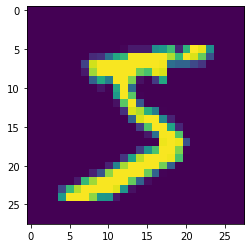

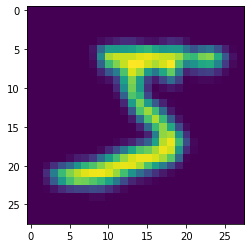

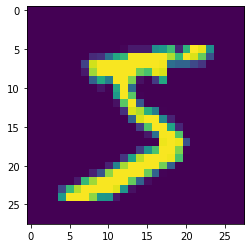

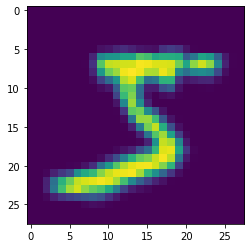

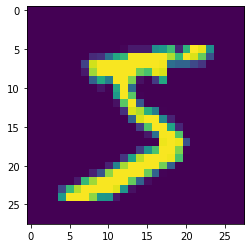

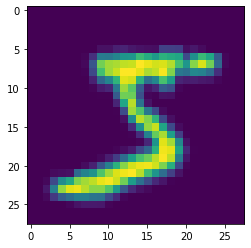

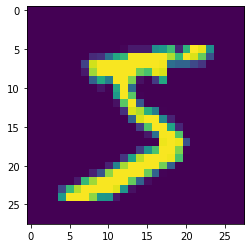

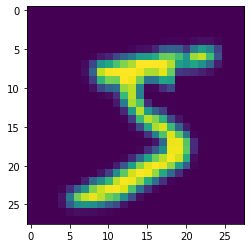

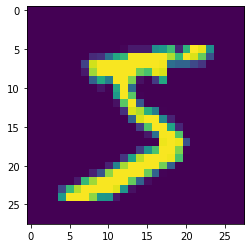

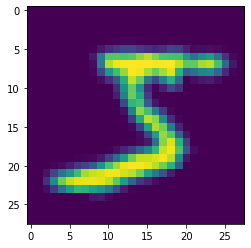

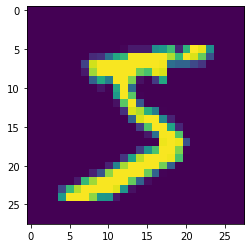

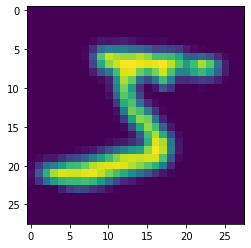

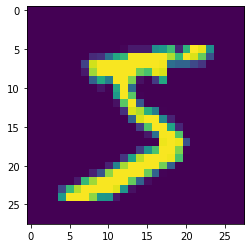

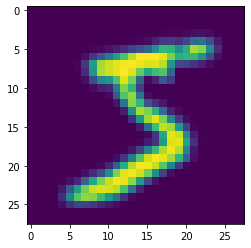

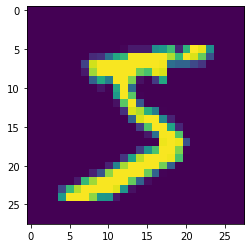

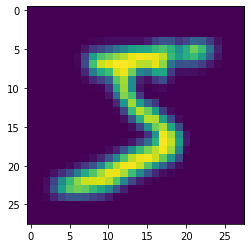

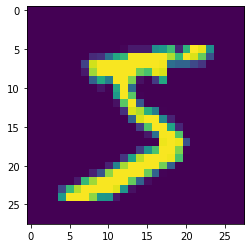

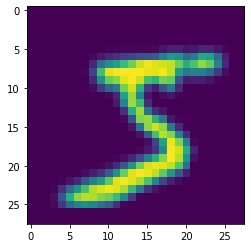

In [79]:
import matplotlib.pyplot as plt

for i in range(9):
    augmented_img = data_augmentation(imgs)
    plt.imshow(imgs[0])
    plt.show()
    plt.imshow(augmented_img[0])
    plt.show()

??? 중간에 말도 안되는 회전이 껴있어서 성능이 안좋아진듯 ㅡㅡ  
생각해보니 flip 왜 넣음?? 큰일 나려고..


---
## 1사이클 스케줄링

In [93]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [96]:
import math 
K = keras.backend

n_epochs = 20
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.01)

one_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

one_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
one_model.fit(train_ds, epochs=20, validation_data=valid_ds, callbacks=[onecycle])

Epoch 1/20
215/215 [==============================] - 4s 16ms/step - loss: 0.8411 - accuracy: 0.7259 - val_loss: 0.0599 - val_accuracy: 0.9846
Epoch 2/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1740 - accuracy: 0.9481 - val_loss: 0.0490 - val_accuracy: 0.9862
Epoch 3/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1281 - accuracy: 0.9609 - val_loss: 0.0459 - val_accuracy: 0.9872
Epoch 4/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1210 - accuracy: 0.9647 - val_loss: 0.0383 - val_accuracy: 0.9900
Epoch 5/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1052 - accuracy: 0.9676 - val_loss: 0.0407 - val_accuracy: 0.9882
Epoch 6/20
215/215 [==============================] - 3s 15ms/step - loss: 0.1007 - accuracy: 0.9694 - val_loss: 0.0418 - val_accuracy: 0.9892
Epoch 7/20
215/215 [==============================] - 3s 15ms/step - loss: 0.0943 - accuracy: 0.9708 - val_loss: 0.0466 - val_accuracy: 0.9888

In [97]:
one_pred = one_model.predict(X_test)
one_y = np.argmax(one_pred, axis=-1)
accuracy_score(one_y, y_test)

0.994

아직 원리는 잘 모르지만 **1사이클 스케줄링**을 사용했더니  
> 더 빨리 좋은 솔루션에 수렴함을 확인함

In [98]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [99]:
one_model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu", input_shape=[28, 28, 1]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

one_model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

430/430 [==============================] - 6s 12ms/step - loss: 1.9550 - accuracy: 0.4396


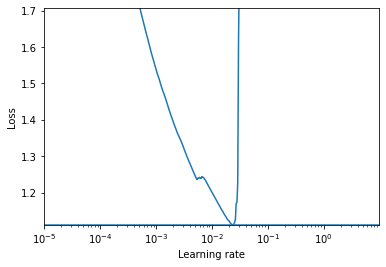

In [102]:
batch_size = 128
rates, losses = find_learning_rate(one_model, X_train, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)